# importing libraries and data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#importing data
df = pd.read_csv("/content/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
#remomving integer index column and adding index to dataframe
df.reset_index(drop=True, inplace = True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# EDA

## null value analysis

In [ ]:
print(df.isnull().sum())

statement    362
status         0
dtype: int64


In [ ]:
#dropping missing statements
df = df.dropna()
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [ ]:
#checking unique status values
df['status'].nunique()

7

## plots and distributions

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

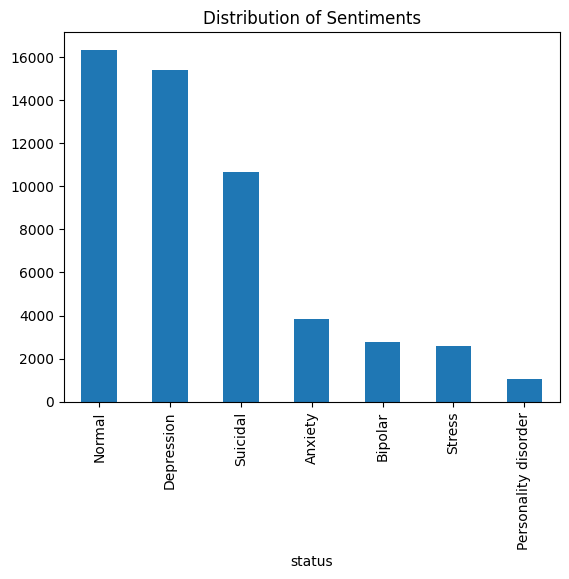

In [ ]:
sentvals=df['status'].value_counts()
print(sentvals)
df['status'].value_counts().plot(kind='bar', title='Distribution of Sentiments')

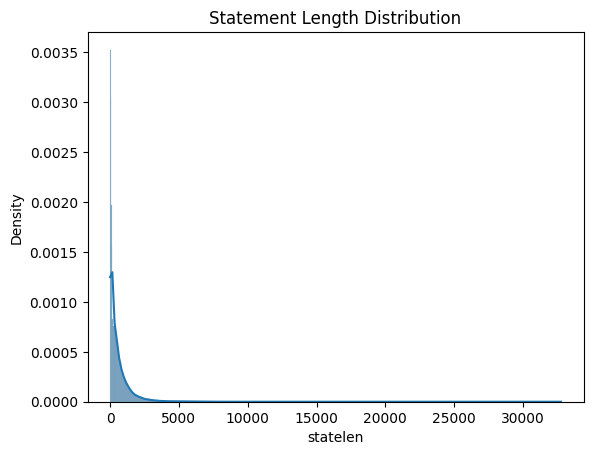

In [ ]:
#statementh length
df['statelen'] = df['statement'].apply(lambda s : len(s) if s == s else 0)
sns.histplot(
   df['statelen'], kde=True,
    stat="density"
)
plt.title('Statement Length Distribution')
plt.show()

## box distribution

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=df['statelen'].values,
    name='Statement Length',
    boxpoints=False, # no data points
    boxmean='sd' # represent mean and standard deviation
))
fig.update_layout(title='Statement length distribution')
fig.show()

In [ ]:
# Sort by statelen to get top 10 shortest and longest statements
shortest_statements = df.nsmallest(10, 'statelen')
longest_statements = df.nlargest(10, 'statelen')

# Create an interactive barplot for shortest statements
fig_shortest = px.bar(
    shortest_statements,
    x='statelen',
    y='status',
    color='status',
    orientation='h',
    title='Top 10 Shortest Statements with Status',
    labels={'statelen': 'Length of Statement', 'status': 'Status'},
    hover_data={'statement': True, 'statelen': True, 'status': True},
    template = "plotly_dark"
)

# Customize layout for shortest statements plot
fig_shortest.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=400,
    margin=dict(l=150, r=50, t=50, b=50),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")

)

# Create an interactive barplot for longest statements
fig_longest = px.bar(
    longest_statements,
    x='statelen',
    y='status',
    color='status',
    orientation='h',
    title='Top 10 Longest Statements with Status',
    labels={'statelen': 'Length of Statement', 'status': 'Status'},
    template = "plotly_dark",
    hover_data={'statement': True, 'statelen': True, 'status': True}
)

# Customize layout for longest statements plot
fig_longest.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=400,
    margin=dict(l=150, r=50, t=50, b=50),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"
    )
)

# Show the plots
fig_shortest.show()
fig_longest.show()

In [ ]:
fig = go.Figure()
for stat in df.status.unique():
    fig.add_trace(go.Box(
        y=df.loc[df['status'] == stat, 'statelen'].values,
        name=f'{stat}',
        boxpoints=False, # no data points
        boxmean='sd' # represent mean and standard deviation
    ))
fig.update_layout(title='statement length distribution for each status')
fig.show()

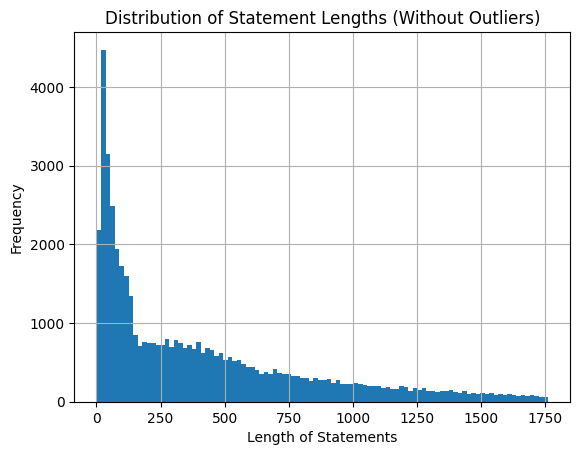

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['statelen'].quantile(0.25)
Q3 = df['statelen'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(df['statelen'] >= lower_bound) & (df['statelen'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['statelen'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

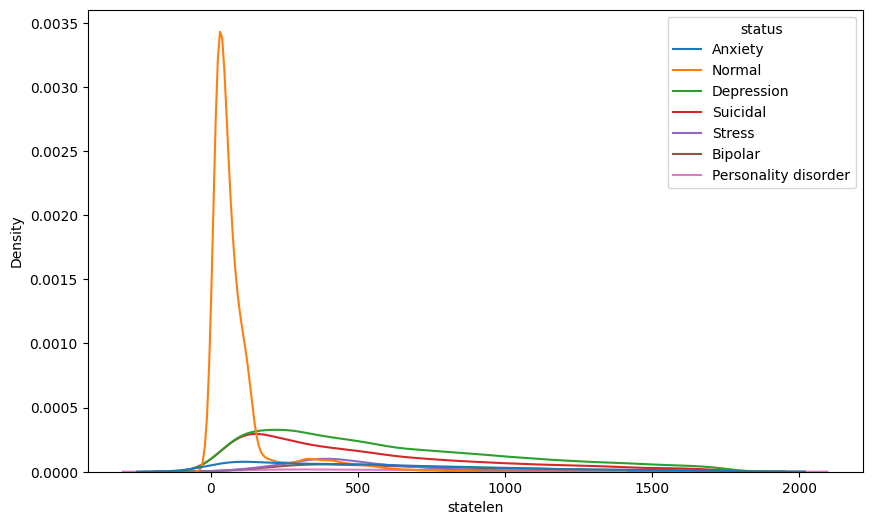

In [ ]:
filtered_df["statelen"]=filtered_df["statement"].apply(len)

fig=plt.figure(figsize=(10,6))

sns.kdeplot(
    x=filtered_df["statelen"],
    hue=filtered_df["status"]
)
plt.show()

## Data cleaning

### duplicate analysis

In [ ]:
duplidf = filtered_df.loc[filtered_df.statement.duplicated(keep=False)]
print("number of duplicated values : ",duplidf.shape[0])
duplidf.head()

number of duplicated values :  2776


,statement,status,statelen
18,"""No regrets or grudges/angry at things that ha...",Anxiety,123
39,but my heart is still restless even though my ...,Anxiety,62
97,"""No regrets or grudges/angry at things that ha...",Anxiety,123
132,I want to exhale the restlessness in my chest ...,Anxiety,60
138,but my heart is still restless even though my ...,Anxiety,62


checking if the duplicated statements have same column value

In [ ]:
groupduplidf = duplidf.groupby(['statement'])['status'].apply(set).reset_index()
groupduplidf.head(10)

,statement,status
0,"""Buy Friends"" comment? My mother doesn't have ...",{Anxiety}
1,"""Desk Toys for Your Stressful Day!"" \n\nDesk ...",{Stress}
2,"""No regrets or grudges/angry at things that ha...",{Anxiety}
3,"""Reduce Worry and Chill Out – The Best Gummies...",{Stress}
4,#NAME?,"{Stress, Depression, Normal, Suicidal}"
5,.5 mg lorazepam and drinking If I take .5 mg o...,{Anxiety}
6,10 years of Celexa/Lexapro and thinking of mak...,{Anxiety}
7,"2 week depression episode Hi Everyone,\n\nI wa...",{Depression}
8,2023 sucks so much for me right now. My PC sud...,{Stress}
9,29 and just started stress smoking Feels weird...,{Stress}


In [ ]:
#checking how many statements reflect more than one diagnosis
groupduplidf.loc[groupduplidf['status'].apply(len) > 1]

,statement,status
4,#NAME?,"{Stress, Depression, Normal, Suicidal}"
38,"All this work, all this pressure that everyone...","{Depression, Suicidal}"
85,Are my anti-depressants not working? I’ve (22F...,"{Depression, Anxiety}"
100,"Because not really. I would have survived, I a...","{Stress, Normal}"
391,I am a drug abuser (benzos and meth mostly) an...,"{Depression, Suicidal}"
408,"I cant function anymore, my cognitive abilitie...","{Depression, Anxiety}"
464,I have been at home the past year... quite lit...,"{Depression, Suicidal}"
497,I refuse to carry both of us anymore and I'm a...,"{Stress, Normal}"
672,Moving back in w my parents at 23 I’m a 23 yo ...,"{Depression, Anxiety}"
688,My twin betrayed me and it cost me some of my ...,"{Depression, Suicidal}"


In [ ]:
#checking for statements which have an unusual amount of multi similarity
groupduplidf.loc[groupduplidf['status'].apply(len) > 2]

,statement,status
4,#NAME?,"{Stress, Depression, Normal, Suicidal}"


meaning #NAME? has insconsistent status
there fore we will remove this statement

In [ ]:
# remove "#NAME?"
filtered_df = filtered_df.loc[filtered_df['statement'] != "#NAME?"]
# drop duplicate, keep only first row
filtered_df.drop_duplicates(subset=['statement'],keep='first', inplace=True)

### case folding

In [ ]:
#cleaning text
import string
def cleantext(state):
    #Case folding
    state = state.str.lower()
    state = state.str.replace(r'[^\w\s]', '', regex = True)
    #remove characters that are not alphanumeric or whitespace, leaving only letters, numbers, and spaces
    state = state.str.replace("\n" , '', regex = True)
    state = state.str.replace('\d', '', regex = True)
    state = state.str.replace(r'\[.*?\]', '', regex = True)
    state = state.str.replace(r'https?://\S+|www\.\S+', '', regex =True)
    state = state.str.replace(r'<.*?>+', '', regex = True)
    state = state.str.replace(r'\w*\d\w*', '', regex = True)
    return state
#The result is a cleaner text with only relevant words, stripped of extraneous information

In [ ]:
filtered_df["statement"] = cleantext(filtered_df["statement"])

In [ ]:
filtered_df.head(10)

,statement,status,statelen
0,oh my gosh,Anxiety,10
1,trouble sleeping confused mind restless heart ...,Anxiety,64
2,all wrong back off dear forward doubt stay in ...,Anxiety,78
3,ive shifted my focus to something else but im ...,Anxiety,61
4,im restless and restless its been a month now ...,Anxiety,72
5,every break you must be nervous like something...,Anxiety,76
6,i feel scared anxious what can i do and may my...,Anxiety,78
7,have you ever felt nervous but didnt know why,Anxiety,47
8,i havent slept well for days its like im rest...,Anxiety,70
9,im really worried i want to cry,Anxiety,34


## removing stopwords

In [ ]:
def removestopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

In [ ]:
filtered_df["statement"] = removestopwords(filtered_df["statement"])

In [ ]:
filtered_df.head(10)

,statement,status,statelen
0,oh gosh,Anxiety,10
1,trouble sleeping confused mind restless heart ...,Anxiety,64
2,wrong back dear forward doubt stay restless re...,Anxiety,78
3,ive shifted focus something else im still worried,Anxiety,61
4,im restless restless month boy mean,Anxiety,72
5,every break must nervous like something wrong ...,Anxiety,76
6,feel scared anxious may family us protected,Anxiety,78
7,ever felt nervous didnt know,Anxiety,47
8,havent slept well days like im restless huh,Anxiety,70
9,im really worried want cry,Anxiety,34


## encoding

In [ ]:
filtered_df["status"] = filtered_df["status"].map({'Anxiety':0, 'Normal':1, 'Depression':2, 'Suicidal':3, 'Stress':4, "Bipolar": 5, "Personality disorder": 6})

# data pre - processing

In [ ]:
fdf = filtered_df.copy()
fdf.reset_index(drop=True, inplace = True)

## stemming

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus=[]
for i in range (0,len(fdf)):
  review = re.sub('[^a-zA-Z0-9]',' ',fdf['statement'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
y  = fdf['status']
len(corpus)

47678

## train test split

In [ ]:
#train test split
x_train,x_test,y_train,y_test=train_test_split(corpus ,y,random_state=42,test_size=0.2)
len(x_train)

38142

## TF-IDF vectorization

In [ ]:
vec=TfidfVectorizer()
x_train_tfidf=vec.fit_transform(x_train)
x_test_tfidf=vec.transform(x_test)

In [ ]:
print(x_train_tfidf.shape,x_test_tfidf.shape)
x_train_tfidf.toarray()
x_test_tfidf.toarray()

(38142, 44147) (9536, 44147)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## creating bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500,ngram_range=(1,2))
x_train_tfidf = cv.fit_transform(x_train_tfidf).toarray()

AttributeError: 'csr_matrix' object has no attribute 'lower'

In [ ]:
x_test = cv.transform(x_test_tfidf).toarray()

# model training

## 1. Random forest classifier

In [ ]:
rf=RandomForestClassifier()
rf.fit(x_train_tfidf,y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.85      0.53      0.65       661
           1       0.81      0.95      0.87      3235
           2       0.53      0.77      0.63      2659
           3       0.65      0.45      0.54      1871
           4       0.88      0.03      0.06       462
           5       0.96      0.29      0.44       470
           6       1.00      0.02      0.03       178

    accuracy                           0.68      9536
   macro avg       0.81      0.43      0.46      9536
weighted avg       0.72      0.68      0.65      9536



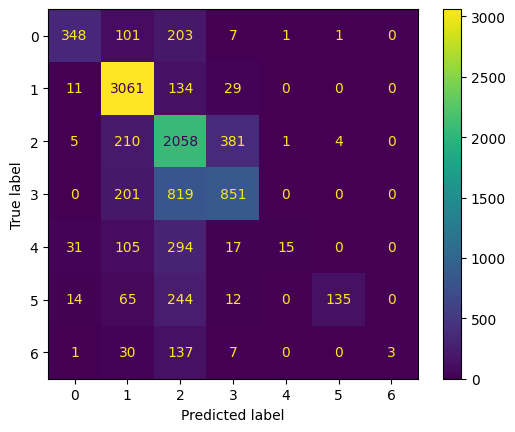

In [ ]:
pred=rf.predict(x_test_tfidf)
print(classification_report(y_test,pred))
cm = confusion_matrix(y_test,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#confusion matrix
disp.plot()
plt.show()

## 2. Decision Tree classifier

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train_tfidf,y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       661
           1       0.84      0.86      0.85      3235
           2       0.60      0.59      0.59      2659
           3       0.52      0.57      0.54      1871
           4       0.33      0.29      0.31       462
           5       0.60      0.53      0.56       470
           6       0.37      0.28      0.32       178

    accuracy                           0.65      9536
   macro avg       0.56      0.53      0.54      9536
weighted avg       0.65      0.65      0.65      9536



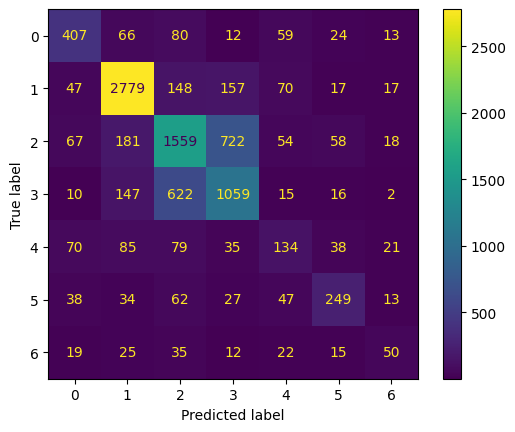

In [ ]:
dtpred=dt.predict(x_test_tfidf)
print(classification_report(y_test,dtpred))
cm = confusion_matrix(y_test,dtpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#confusion matrix
disp.plot()
plt.show()

## 3. Ada boost classifier

In [ ]:
ada = AdaBoostClassifier()
ada.fit(x_train_tfidf,y_train)

AdaBoostClassifier()

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       661
           1       0.77      0.90      0.83      3235
           2       0.64      0.62      0.63      2659
           3       0.60      0.57      0.59      1871
           4       0.51      0.29      0.37       462
           5       0.80      0.66      0.73       470
           6       0.62      0.43      0.51       178

    accuracy                           0.69      9536
   macro avg       0.66      0.59      0.62      9536
weighted avg       0.68      0.69      0.68      9536



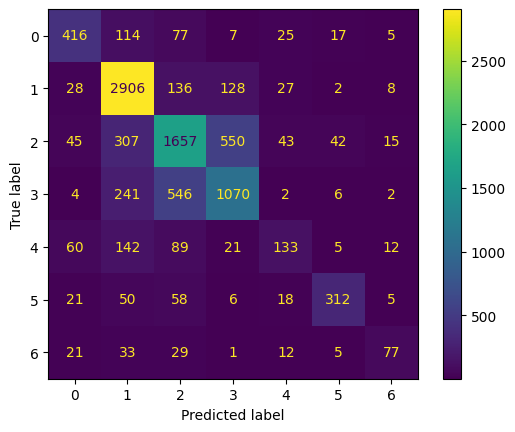

In [ ]:
adapred=ada.predict(x_test_tfidf)
print(classification_report(y_test,adapred))
cm = confusion_matrix(y_test,adapred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#confusion matrix
disp.plot()
plt.show()

## 4. Logistic regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       661
           1       0.85      0.94      0.89      3235
           2       0.68      0.72      0.70      2659
           3       0.67      0.64      0.65      1871
           4       0.63      0.42      0.50       462
           5       0.88      0.68      0.77       470
           6       0.84      0.40      0.55       178

    accuracy                           0.76      9536
   macro avg       0.76      0.65      0.69      9536
weighted avg       0.75      0.76      0.75      9536



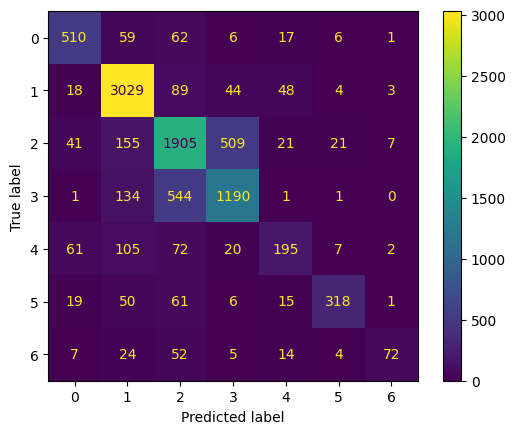

In [ ]:
lrpred=lr.predict(x_test_tfidf)
print(classification_report(y_test,lrpred))
cm = confusion_matrix(y_test,lrpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#confusion matrix
disp.plot()
plt.show()

better than the rest when predicted without hyperparameter tuning

### hyperparameter tuning

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(x_train_tfidf, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Evaluate on the test set
test_score = grid_search.score(x_test_tfidf, y_test)
print("Test Set Accuracy:", test_score)